In [1]:
#import mdtraj
import os

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import SDWriter
from rdkit.Chem import AllChem
from rdkit.Chem import MolFromSmarts
from rdkit.Chem import rdmolops
from rdkit.Chem import rdchem
from molvs import Standardizer
from render_svg import *
from drawit import drawit

ModuleNotFoundError: No module named 'render_svg'

In [4]:
ifilename = "molekula.txt"

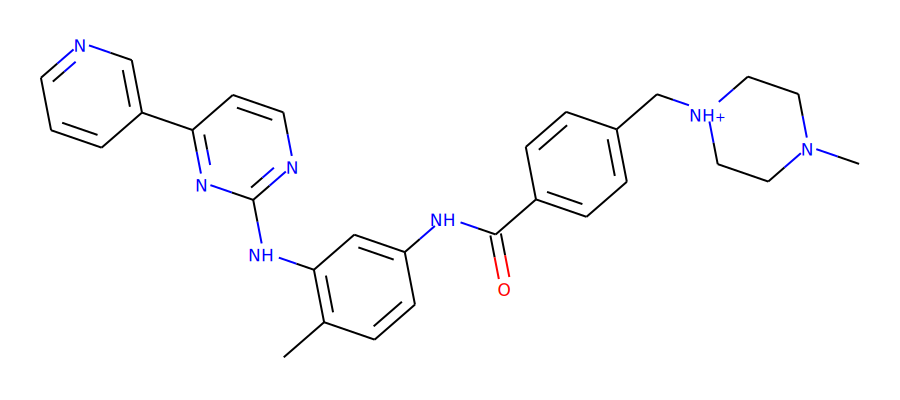

In [5]:
ifile = open(ifilename, "r").readlines()
smiles_molecule = str.split(ifile[0])[0]

molecule = Chem.MolFromSmiles(smiles_molecule)

render_svg(moltosvg(molecule))

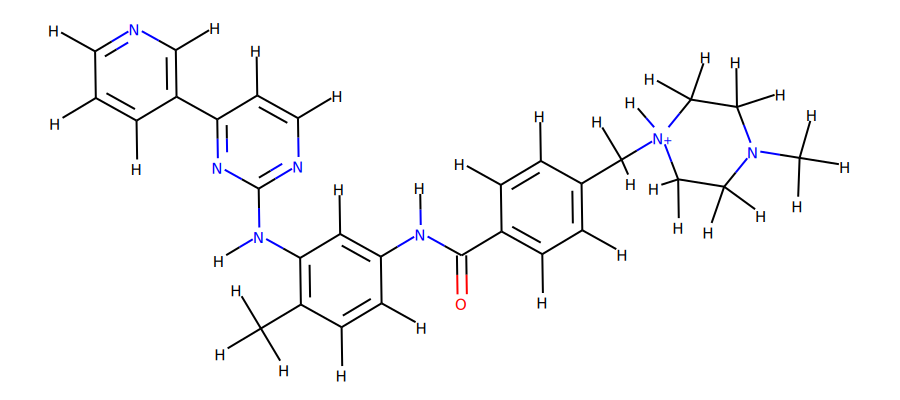

In [70]:
smifile = open("molekula.smi", "w")
smifile.write(smiles_molecule)
smifile.close()

molecule = Chem.MolFromSmiles(smiles_molecule)
#Draw.MolToFile(molecule,'molekula.png')
s = Standardizer()
molecule = s.standardize(molecule)
molecule = Chem.AddHs(molecule)
natoms = molecule.GetNumAtoms()

render_svg(moltosvg(molecule))

In [71]:
#set parameters
numc = 50 #00
minid = 0
minene = 100000000000.0

In [72]:
#find most stable configuration
molecules = AllChem.EmbedMultipleConfs(molecule, clearConfs=True, numConfs=numc)
done = AllChem.MMFFOptimizeMoleculeConfs(molecule)

for i in range(len(done)):
  if done[i][1]<minene:
    minene = done[i][1]
    minid = i
print(f'minid: {minid}')
print(f'minene: {minene}')

writer = SDWriter("molekula.mol")
writer.write(molecule, confId=minid)

drawit(molecule)

minid: 45
minene: 76.39642733057174


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [73]:
RotatableBond = Chem.MolFromSmarts('[!$([NH]!@C(=O))&!D1&!$(*#*)&!$([C;H3])&!$([O;H1])&!$([N;H3])]-&!@[!$([NH]!@C(=O))&!D1&!$(*#*)&!$([C;H3])&!$([O;H1])&!$([N;H3])]')
rotatables = molecule.GetSubstructMatches(RotatableBond)
print(rotatables)

((2, 24), (8, 10), (13, 16), (16, 17), (24, 25), (29, 31))


In [74]:
torsions = []
for rotatable in rotatables:
  pairs1 = []
  pairs2 = []
  for bond in molecule.GetBonds():
    if rotatable[0]==bond.GetBeginAtomIdx() and rotatable[1]!=bond.GetEndAtomIdx():
      pairs1.append([bond.GetBeginAtomIdx(),bond.GetEndAtomIdx()])
    if rotatable[1]==bond.GetBeginAtomIdx() and rotatable[0]!=bond.GetEndAtomIdx():
      pairs2.append([bond.GetBeginAtomIdx(),bond.GetEndAtomIdx()])
  torsions.append([pairs1[0][1],pairs1[0][0],pairs2[0][0],pairs2[0][1]])
print(torsions)

[[3, 2, 24, 25], [9, 8, 10, 11], [14, 13, 16, 17], [48, 16, 17, 18], [62, 24, 25, 26], [30, 29, 31, 32]]


In [75]:
netcharge = rdmolops.GetFormalCharge(molecule)
command = "antechamber -i molekula.mol -fi mdl -o molekula.prepi -fo prepi -c bcc -nc "+str(netcharge)
os.system(command)

command = "parmchk -i molekula.prepi -f prepi -o molekula.frcmod"
os.system(command)

command = "tleap -f tleapin.txt"
os.system(command)

command = "./acpype.py -p molekula.prmtop -x molekula.inpcrd"
os.system(command)

os.system("mkdir em")
emfile = open("em/em.mdp", "w")
emfile.write("integrator          =  steep\n")
emfile.write("nsteps              =  100000\n")
emfile.write("emtol               =  0\n")
emfile.write("emstep              =  0.1\n")
emfile.write("nstcomm             =  1\n")
emfile.write("nstxout             =  100\n")
emfile.write("nstvout             =  100\n")
emfile.write("nstfout             =  0\n")
emfile.write("nstlog              =  100\n")
emfile.write("nstenergy           =  100\n")
emfile.write("nstlist             =  1\n")
emfile.write("ns_type             =  grid\n")
emfile.write("coulombtype         =  cut-off\n")
emfile.write("rlist               =  1.4\n")
emfile.write("rcoulomb            =  1.4\n")
emfile.write("rvdw                =  1.4\n")
emfile.write("energygrps          =  System\n")
emfile.write("epsilon-r           =  80\n")
emfile.write("\n")
emfile.close()
os.system("cp MOL_GMX.gro em/")
os.system("cp MOL_GMX.top em/")
command = "cd em; /usr/local/chemistry/gromacs512/bin/gmx_d editconf -f MOL_GMX -o box -c -box 3 3 3"
os.system(command)
command = "cd em; /usr/local/chemistry/gromacs512/bin/gmx_d grompp -f em.mdp -c box -p MOL_GMX -o em1"
os.system(command)
command = "cd em; /usr/local/chemistry/gromacs512/bin/gmx_d mdrun -deffnm em1"
os.system(command)

32512

In [76]:
os.system("mkdir md")
mdfile = open("md/md.mdp", "w")
mdfile.write("integrator          = sd\n")
mdfile.write("nsteps              = 100000\n")
mdfile.write("dt                  = 0.001\n")
mdfile.write("nstxout             = 1000\n")
mdfile.write("nstvout             = 1000\n")
mdfile.write("nstenergy           = 1000\n")
mdfile.write("nstlog              = 1000\n")
mdfile.write("continuation        = no\n")
mdfile.write("constraints         = none\n")
mdfile.write("cutoff-scheme       = Verlet\n")
mdfile.write("ns_type             = grid\n")
mdfile.write("nstlist             = 1\n")
mdfile.write("rlist               = 1.4\n")
mdfile.write("rcoulomb            = 1.4\n")
mdfile.write("rvdw                = 1.4\n")
mdfile.write("coulombtype         = cut-off\n")
mdfile.write("tcoupl              = V-rescale\n")
mdfile.write("tc-grps             = system\n")
mdfile.write("tau_t               = 0.1\n")
mdfile.write("ref_t               = 300\n")
mdfile.write("pcoupl              = no\n")
mdfile.write("pbc                 = xyz\n")
mdfile.write("gen_vel             = yes\n")
mdfile.write("epsilon-r           = 80\n")
mdfile.write("\n")
mdfile.close()
os.system("cp em/em1.gro md/")
os.system("cp MOL_GMX.top md/")
command = "cd md; /usr/local/chemistry/gromacs512/bin/gmx_d grompp -f md.mdp -c em1 -p MOL_GMX -o md1"
os.system(command)
command = "cd md; /usr/local/chemistry/gromacs512/bin/gmx_d mdrun -deffnm md1"
os.system(command)

32512

In [77]:
for i in range(len(torsions)):
  fr = str(float(100-len(torsions)+i)-0.01)
  to = str(float(100-len(torsions)+i)+0.01)
  command = "cd md; /usr/local/chemistry/gromacs512/bin/gmx_d trjconv -s md1 -f md1 -o frame"+str(i)+".gro -b "+fr+" -e "+to+"<<EOF\n0\nEOF"
  os.system(command)

os.system("mkdir mtd")
mtdfile = open("mtd/mtd.mdp", "w")
mtdfile.write("integrator          = sd\n")
mtdfile.write("nsteps              = 1000000\n")
mtdfile.write("dt                  = 0.001\n")
mtdfile.write("nstxout             = 1000\n")
mtdfile.write("nstvout             = 1000\n")
mtdfile.write("nstenergy           = 1000\n")
mtdfile.write("nstlog              = 1000\n")
mtdfile.write("continuation        = no\n")
mtdfile.write("constraints         = none\n")
mtdfile.write("cutoff-scheme       = Verlet\n")
mtdfile.write("ns_type             = grid\n")
mtdfile.write("nstlist             = 1\n")
mtdfile.write("rlist               = 1.4\n")
mtdfile.write("rcoulomb            = 1.4\n")
mtdfile.write("rvdw                = 1.4\n")
mtdfile.write("coulombtype         = cut-off\n")
mtdfile.write("tcoupl              = V-rescale\n")
mtdfile.write("tc-grps             = system\n")
mtdfile.write("tau_t               = 0.1\n")
mtdfile.write("ref_t               = 300\n")
mtdfile.write("pcoupl              = no\n")
mtdfile.write("pbc                 = xyz\n")
mtdfile.write("gen_vel             = yes\n")
mtdfile.write("epsilon-r           = 80\n")
mtdfile.write("\n")
mtdfile.close()


In [78]:
for i in range(len(torsions)):
  plumeddat = open("mtd/plumed"+str(i)+".dat", "w")
  plumeddat.write("RANDOM_EXCHANGES\n")
  plumeddat.write("WHOLEMOLECULES ENTITY0=1-%i\n" % natoms)
  for j in range(len(torsions)):
    plumeddat.write("TORSION ATOMS=%i,%i,%i,%i LABEL=cv%i\n" % (torsions[j][0],torsions[j][1],torsions[j][2],torsions[j][3],j+1))
  plumeddat.write("METAD ARG=cv%i HEIGHT=0.5 SIGMA=0.3 PACE=1000 GRID_MIN=-pi GRID_MAX=pi BIASFACTOR=15 LABEL=be\n" % (i+1))
  cvs = ""
  for j in range(len(torsions)):
    cvs=cvs+"cv"+str(j+1)+","
  cvs = cvs[:-1]
  plumeddat.write("PRINT ARG=%s STRIDE=1000 FILE=COLVAR\n" % cvs)
  plumeddat.write("PRINT ARG=be.bias STRIDE=1000 FILE=BIAS\n")
  plumeddat.close()

os.system("cp md/fra*.gro mtd/")
os.system("cp MOL_GMX.top mtd/")
command = "cd mtd; /usr/local/chemistry/gromacs512/bin/gmx_d grompp -f mtd.mdp -c md1 -p MOL_GMX -o mtd1"
#os.system(command)
command = "cd mtd; mpirun -np "+str(len(torsions))+" /usr/local/chemistry/gromacs512/bin/gmx_d mdrun -deffnm mtd1"
#os.system(command)
